## 0. Initial setup

In [89]:
import dateutil
import elasticsearch
import elasticsearch_dsl
import numpy as np
import pandas as pd
import simplejson as json
import textblob
import wordcloud

In [88]:
with open('secrets.txt', 'r') as f:
    env = json.load(f)
print('Loaded env vars')

Loaded env vars


### Using textblob for quick polarity

In [ ]:
for t in tweets[0:50]:
    print('Tweet:\n' + t)
    blob = TextBlob(t)
    sents = blob.sentences
    if len(sents) >= 1:
        sent = sents[0]
        print(sent.sentiment)
    print('')

## 1. Retrieving tweets with tweepy

In [ ]:
import tweepy

In [ ]:
# env vars are set at the top of the file.

auth = tweepy.OAuthHandler(env[tw_oauth_key], env[tw_oauth_secret])
auth.set_access_token(env[tw_token_key], env[tw_token_secret])

api = tweepy.API(auth)

In [ ]:
bitcoin_tweets = api.search('bitcoin', lang='en', count=100)
print(len(bitcoin_tweets))
print([t.text for t in bitcoin_tweets[0:5]])

In [ ]:
cursor = tweepy.Cursor(api.search, q='bitcoin', lang='en', count=100, tweet_mode='extended')

In [ ]:
tlist = []

for page in cursor.pages(15):
    tlist.extend(page)

print(len(tlist))

In [ ]:
tweets = [t.full_text for t in tlist]
print(len(tweets))

## 3. Retrieving tweets from ElasticSearch

In [ ]:
# Create a model for tweets stored in the elasticsearch instance:
import elasticsearch
import elasticsearch_dsl

class ESTweet(elasticsearch_dsl.Document):
    created_at = elasticsearch_dsl.Date()
    stored_at = elasticsearch_dsl.Date()
    full_text = elasticsearch_dsl.Text(analyzer='snowball')
    subjectivity = elasticsearch_dsl.Float()
    polarity = elasticsearch_dsl.Float()
    author_id = elasticsearch_dsl.Integer()
    author_followers = elasticsearch_dsl.Integer()

    class Index:
        name = 'tweets'


In [92]:
# env vars are loaded at the beginning of the file.
es_client = elasticsearch.Elasticsearch(hosts=[env['es_endpoint']])

def get_tweets_from_elasticsearch(max_tweets=50000):
    max_page_size = 10000
    tweet_hits = []
    for page in range(math.ceil(max_tweets / max_page_size)):
        start = page * max_page_size
        end = min((page + 1) * max_page_size, max_tweets)
        print(f'retrieving page {page} from {start} to {end}')
        search = elasticsearch_dsl.Search(index='tweets').using(es_client)\
                    .query('match_all')\
                    .sort({'created_at': {'order': 'desc'}})[start:end]
        search.execute()

        for hit in search:
            tweet_hits.append(hit)
    return tweet_hits


def scan_all_tweets_from_elasticsearch(max_tweets=5000):
    tweet_hits = []
    search = elasticsearch_dsl.Search(index='tweets').using(es_client).query('match_all')
    search.execute()

    for hit in search.scan():
        tweet_hits.append(hit)
        if len(tweet_hits) >= max_tweets:
            break
    return tweet_hits

def hitlist_to_dataframe(hit_list):
    """
    Transform tweet hitlist (from Elasticsearch) to a dataframe
    """
    id_strs = []
    created_ats = []
    full_texts = []
    ndropped = 0
    for hit in hit_list:
        id_str = str(hit.meta.id)
        
        if 'created_at' in hit and 'full_text' in hit:
            id_strs.append(id_str)
            created_ats.append(dateutil.parser.parse(hit['created_at']))
            full_texts.append(hit['full_text'])
        else:
            ndropped += 1
    df = pd.DataFrame({'id_str': id_strs, 'created_at': created_ats, 'full_text': full_texts})
    print('ndropped = {}'.format(ndropped))
    return df


In [ ]:
df_tweets = hitlist_to_dataframe(tweet_hits)
tweet_hits = None # ready for garbage collection

df_tweets.head(10)

In [ ]:
df_tweets.set_index(df_tweets['created_at'])
df_tweets = df_tweets.drop(columns=['id_str', 'created_at'])
df_tweets.head()

## 4. NLP on tweets using Sentiment Analysis Dataset (SAD)

In [73]:
import re

import dill
import matplotlib.pyplot as plt
import nltk.tokenize
import numpy as np
import pandas as pd
import sklearn.feature_extraction.text
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.pipeline
from sklearn import base

### 4.1. Load the dataset

In [3]:
df_sad = pd.read_csv('Sentiment Analysis Dataset.csv', error_bad_lines=False)
print(df_sad.shape)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


(1578612, 4)


In [4]:
labels_sad = df_sad['Sentiment']
labels_sad.head()

0    0
1    0
2    1
3    0
4    0
Name: Sentiment, dtype: int64

In [5]:
df_text = df_sad.drop(columns=['ItemID', 'Sentiment', 'SentimentSource'])
df_text.head()

,SentimentText
0,is so sad for my APL frie...
1,I missed the New Moon trail...
2,omg its already 7:30 :O
3,.. Omgaga. Im sooo im gunna CRy. I'...
4,i think mi bf is cheating on me!!! ...


### 4.2. A first pass at cleaning

In [6]:
# Custom nltk transformer for cleaning and tokenizing tweets:
class TwitterPreprocessor(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, column=None):
        self.version = '20190218' # update this whenever changing the code!
        self.column = column # column to pull tweet text from
        self.tw_tokenizer = nltk.tokenize.TweetTokenizer(
            strip_handles=True, reduce_len=True, preserve_case=False)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        ans = X[self.column].apply(self._prepare_tweet)
        return ans
        
    def _prepare_tweet(self, tweet):
        tweet = re.sub(r'\bhttps?\S+', '', tweet) # Eliminate urls
        tokens = self.tw_tokenizer.tokenize(tweet)
        clean_tweet = ' '.join([t for t in tokens if len(t) > 1 or t == 'i'])
        return clean_tweet


In [7]:
tw_preprocessor = TwitterPreprocessor(column='SentimentText')
df_preprocessed = tw_preprocessor.transform(df_text)
df_preprocessed.head()

0                      is so sad for my apl friend ...
1                    i missed the new moon trailer ...
2                                 omg its already 7:30
3    .. omgaga im sooo im gunna cry i've been at th...
4                  i think mi bf is cheating on me t_t
Name: SentimentText, dtype: object

In [8]:
dill.dump(df_preprocessed, open('df_preprocessed_v20190218.dill', 'wb'))

In [ ]:
df_preprocessed: pd.core.series.Series = dill.load(open('df_preprocessed_v20190218.dill', 'rb'))

### 4.3. Systematic search for a model

In [28]:
X = df_preprocessed.to_numpy()
X

array(['is so sad for my apl friend ...',
       'i missed the new moon trailer ...', 'omg its already 7:30', ...,
       'zzzzzzzzzz ... wait no i have homework',
       'zzzzzzzzzzzz meh what am i doing up again', 'zzzz i wish'],
      dtype=object)

In [29]:
y = labels_sad.to_numpy()
y.shape

(1578612,)

In [30]:
X_train, X_test, y_train, y_test =\
    sklearn.model_selection.train_test_split(X, y, test_size=0.1, random_state=42)
print(f'X_train: {X_train.shape} -- X_test: {X_test.shape}')
print(f'y_train: {y_train.shape} -- y_test: {y_test.shape}')

X_train: (1420750,) -- X_test: (157862,)
y_train: (1420750,) -- y_test: (157862,)


In [39]:
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(ngram_range=(1,1), max_features=50000)
tfidf_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [40]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_train_tfidf.shape

# max_features=None --> (1420750, 258251) -- 250k features!

(1420750, 50000)

In [41]:
pipe = sklearn.pipeline.Pipeline([
#     ('tfidf_vectorizer', sklearn.feature_extraction.text.TfidfVectorizer(ngram_range=(1,1), min_df=100)),
    ('tfidf_vectorizer', sklearn.feature_extraction.text.TfidfVectorizer(ngram_range=(1,1), max_features=50_000)),
    ('mnb_estimator', sklearn.naive_bayes.MultinomialNB()),
])
pipe

Pipeline(memory=None,
     steps=[('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smoo...   vocabulary=None)), ('mnb_estimator', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [58]:
# First search over alpha:
param_grid = {
    'mnb_estimator__alpha': [4.5, 5.0, 5.5, 6.0]
}

grid_search_cv = sklearn.model_selection.GridSearchCV(
    pipe, param_grid=param_grid, cv=5, verbose=2
)

grid_search_cv.fit(X_train[:200_000], y_train[:200_000])
grid_search_cv.best_estimator_

# 'mnb_estimator__alpha': [0.8, 1.0, 1.5, 5.0] --> winner is 5.0
# 'mnb_estimator__alpha': [4.0, 5.0, 10.0, 20.0] --> winner is 5.0
# 'mnb_estimator__alpha': [4.5, 5.0, 5.5, 6.0]

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] mnb_estimator__alpha=4.5 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... mnb_estimator__alpha=4.5, total=   2.9s
[CV] mnb_estimator__alpha=4.5 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ......................... mnb_estimator__alpha=4.5, total=   2.7s
[CV] mnb_estimator__alpha=4.5 ........................................
[CV] ......................... mnb_estimator__alpha=4.5, total=   2.8s
[CV] mnb_estimator__alpha=4.5 ........................................
[CV] ......................... mnb_estimator__alpha=4.5, total=   2.7s
[CV] mnb_estimator__alpha=4.5 ........................................
[CV] ......................... mnb_estimator__alpha=4.5, total=   2.8s
[CV] mnb_estimator__alpha=5.0 ........................................
[CV] ......................... mnb_estimator__alpha=5.0, total=   2.7s
[CV] mnb_estimator__alpha=5.0 ........................................
[CV] ......................... mnb_estimator__alpha=5.0, total=   2.7s
[CV] mnb_estimator__alpha=5.0 ........................................
[CV] ......................... mnb_estimator__alpha=5.0, total=   2.7s
[CV] mnb_estimator__alpha=5.0 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.7min finished


Pipeline(memory=None,
     steps=[('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smoo...   vocabulary=None)), ('mnb_estimator', MultinomialNB(alpha=5.5, class_prior=None, fit_prior=True))])

In [59]:
grid_search_cv.score(X_train[:200_000], y_train[:200_000])

0.80025

In [60]:
grid_search_cv.score(X_test, y_test)

0.7740431516134345

In [61]:
y_predicted = grid_search_cv.predict(X_test)
y_predicted

array([1, 1, 0, ..., 1, 1, 1])

In [62]:
print(sklearn.metrics.classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78     78921
           1       0.80      0.73      0.76     78941

   micro avg       0.77      0.77      0.77    157862
   macro avg       0.78      0.77      0.77    157862
weighted avg       0.78      0.77      0.77    157862



In [63]:
print(sklearn.metrics.confusion_matrix(y_test, y_predicted))

[[64596 14325]
 [21345 57596]]


### Now train on the full dataset

In [64]:
pipe = sklearn.pipeline.Pipeline([
#     ('tfidf_vectorizer', sklearn.feature_extraction.text.TfidfVectorizer(ngram_range=(1,1), min_df=100)),
    ('tfidf_vectorizer', sklearn.feature_extraction.text.TfidfVectorizer(ngram_range=(1,1), max_features=50_000)),
    ('mnb_estimator', sklearn.naive_bayes.MultinomialNB(alpha=5.5)),
])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smoo...   vocabulary=None)), ('mnb_estimator', MultinomialNB(alpha=5.5, class_prior=None, fit_prior=True))])

In [65]:
pipe.score(X_train, y_train)

0.7866303008974134

In [66]:
pipe.score(X_test, y_test)

0.7784584003750111

In [67]:
y_predicted_final = pipe.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_predicted_final))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78     78921
           1       0.79      0.76      0.78     78941

   micro avg       0.78      0.78      0.78    157862
   macro avg       0.78      0.78      0.78    157862
weighted avg       0.78      0.78      0.78    157862



### Compare with baseline

In [68]:
import textblob

In [75]:
tb_polarity = [get_tb_polarity(tweet) for tweet in X_test]
tb_polarity[:30]

[0.0,
 0.5,
 -0.30000000000000004,
 -0.4,
 0.0,
 0.021666666666666667,
 0.15000000000000002,
 0.0,
 -0.25,
 0.0,
 0.0,
 0.0,
 0.0,
 0.09999999999999998,
 0.0,
 0.1,
 -0.4,
 0.0,
 0.34285714285714286,
 0.32499999999999996,
 0.0,
 0.3181818181818182,
 0.5,
 -0.6999999999999998,
 0.3666666666666667,
 0.2,
 0.0,
 0.6,
 0.2,
 -0.2]

In [78]:
tb_polarity = np.array(tb_polarity)
tb_polarity

array([ 0. ,  0.5, -0.3, ...,  0.5,  0.3,  0. ])

In [79]:
tb_polarity > 0.0

/Users/gdiazc/Google Drive/Data Incubator 2019/workspace/sentiment-dashboard/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([False,  True, False, ...,  True,  True, False])

In [84]:
y_test_tb_prediction = np.array(tb_polarity) >= 0.0
y_test_tb_prediction = y_test_tb_prediction.astype(int)

/Users/gdiazc/Google Drive/Data Incubator 2019/workspace/sentiment-dashboard/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


In [83]:
y_test_tb_prediction.astype(int)

array([1, 1, 0, ..., 1, 1, 1])

In [85]:
print(sklearn.metrics.classification_report(y_test, y_test_tb_prediction))

              precision    recall  f1-score   support

           0       0.76      0.32      0.46     78921
           1       0.57      0.90      0.70     78941

   micro avg       0.61      0.61      0.61    157862
   macro avg       0.67      0.61      0.58    157862
weighted avg       0.67      0.61      0.58    157862



### Save models

In [ ]:
# Reduce the serialized file size
tfidf_vectorizer.stop_words_ = None
tfidf_vectorizer.vocabulary_ = None

In [ ]:
dill.dump(tw_preprocessor, open('tw_preprocessor.dill', 'wb'))
dill.dump(tfidf_vectorizer, open('tfidf_vectorizer.dill', 'wb'))
dill.dump(best_estimator, open('best_mnb_estimator.dill', 'wb'))

## 5. Wordclouds

In [105]:
def build_word_cloud(data, column_name=None, **kwargs):
    """
    Prepare and show a wordcloud.
    """
    corpus = ''
    
    series = data
    if column_name:
        series = data[column_name]
    
    for text in series:
        corpus += text
        corpus += ' '

    cloud = wordcloud.WordCloud(
        width=800, height=450, random_state=21, max_font_size=110, background_color='white', **kwargs
    ).generate(corpus)

    plt.figure(figsize=(8, 5))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()


## 6. Load pre-trained models

In [ ]:
import dill
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [ ]:
tfidf_vectorizer: TfidfVectorizer = dill.load(open('tfidf_vectorizer.dill', 'rb'))
best_estimator: MultinomialNB = dill.load(open('best_mnb_estimator.dill', 'rb'))


In [ ]:
tw_preprocessor = TwitterPreprocessor(column='full_text')

In [ ]:
pipe = sklearn.pipeline.Pipeline([
    ('tw_preprocessor', tw_preprocessor),
    ('tfidf_vectorizer', tfidf_vectorizer),
    ('estimator', best_estimator)
])
pipe

In [ ]:
example = pd.DataFrame({'full_text': ['bitcoin is awesome and it will grow this year']})
print(example)
pipe.predict(example)

### 6.2. Get tweets from elasticsearch

In [93]:
tweet_hits = scan_all_tweets_from_elasticsearch(max_tweets=50_000)

In [94]:
len(tweet_hits)

50000

In [95]:
df_tweets = hitlist_to_dataframe(tweet_hits)

ndropped = 7


In [96]:
tweet_hits = None

In [97]:
df_tweets.head()

,id_str,created_at,full_text
0,5CxggmgB8uluafRYNLrQ,2019-01-25 00:18:36,"RT TechREDEF ""Despite Bitcoin's Dive, a Former..."
1,8SxqgmgB8uluafRYd7px,2019-01-25 00:30:22,#crypto mkt cap winners last 2 hours\n\n$BTC $...
2,_ixrgmgB8uluafRYZbrm,2019-01-25 00:31:15,Bitcoin Vip Mining - an investment project dea...
3,DSxsgmgB8uluafRYqbu8,2019-01-25 00:32:36,Litecoin v Bitcoin Looking Good 😉👍\n\n🎙Podcast...
4,5ixggmgB8uluafRYNrq0,2019-01-25 00:18:24,"RT @iamjosephyoung: On CNBC ETF Edge, VanEck C..."


In [126]:
# df_tweets['full_text_clean'] = tw_preprocessor.transform(df_tweets)

tw_preprocessor.column = 'full_text'
btc_tweets_preprocessed = tw_preprocessor.transform(df_tweets)
btc_tweets_preprocessed = pd.Series(btc_tweets_preprocessed.unique())

In [128]:
btc_tweets_preprocessed.head()

0    rt techredef despite bitcoin's dive former soviet republic is still betting big on it lizalderma...
1         #crypto mkt cap winners last hours btc waves rep bsv ltc doge bat lsk #bitcoin #cryptocurrency
2    bitcoin vip mining an investment project dealing with mining and trading payment proof bitcoin v...
3    litecoin bitcoin looking good podcast #bitcoinpodcast #cryptocurrencypodcast #bitcoin #ethereum ...
4    rt on cnbc etf edge vaneck ceo jan van eck said due to the shutdown vaneck wasn't able to contin...
dtype: object

In [130]:
btc_tweets_preprocessed.shape

(33332,)

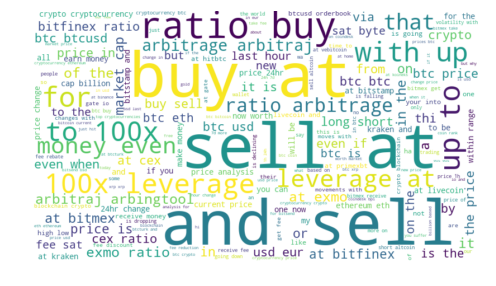

In [140]:
stopwords = ['bitcoin', 'rt']
build_word_cloud(btc_tweets_preprocessed, stopwords=stopwords)

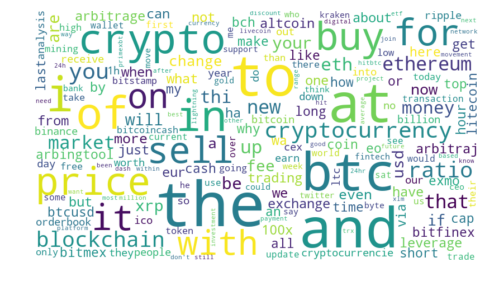

In [141]:
build_word_cloud(btc_tweets_preprocessed, stopwords=stopwords, collocations=False)

In [120]:
btc_tweets_preprocessed.shape

(49993,)

In [122]:
btc_tweets_preprocessed.unique().shape

(33332,)

In [186]:
pd.options.display.max_colwidth = 100

# btc_tweets_preprocessed[btc_tweets_preprocessed.str.contains('buy at')]
# btc_tweets_preprocessed[btc_tweets_preprocessed.str.contains('sell at')]
# btc_tweets_preprocessed[btc_tweets_preprocessed.str.contains('100x leverage')]
btc_tweets_preprocessed[btc_tweets_preprocessed.str.contains('buy sell')]

89       buy sell bitcoin movements with up to 100x leverage 10 fee discount using my link click here btc...
548      buy sell bitcoin altcoin movements with up to 100x leverage at bitmex take 10 fee rebate make mo...
647      buy sell bitcoin changes with up to 100x leverage at bitmex get 10 fee discount click here mtl d...
652      buy sell bitcoin movements with up to 100x leverage at bitmex receive 10 fee rebate make money e...
699      buy sell bitcoin volatility with up to 100x leverage at bitmex take 10 fee discount make money e...
795      buy sell bitcoin volatility with up to 100x leverage at bitmex take 10 fee reduction make money ...
800      buy sell bitcoin altcoin volatility with up to 100x leverage at bitmex get 10 fee rebate earn mo...
899      buy sell bitcoin changes with up to 100x leverage at bitmex get 10 fee reduction make money even...
950      buy sell bitcoin moves with up to 100x leverage at bitmex take 10 fee discount make money even i...
982      buy sell b

In [151]:
def no_hashtag_len(tweet):
    return len(re.sub(r'#\w+', '', tweet))

def no_hashtag_ratio(tweet):
    return len(re.sub(r'#\w+', '', tweet)) / len(tweet)

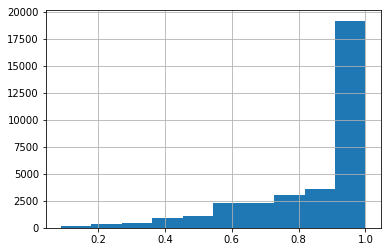

In [159]:
btc_tweets_preprocessed.apply(no_hashtag_ratio).hist()

In [160]:
btc_tweets_preprocessed[btc_tweets_preprocessed.apply(no_hashtag_ratio) > 0.8]

0        rt techredef despite bitcoin's dive former soviet republic is still betting big on it lizalderma...
4        rt on cnbc etf edge vaneck ceo jan van eck said due to the shutdown vaneck wasn't able to contin...
6        rt jp morgan report bitcoin could fall below 1,260 while banks will not benefit from blockchain ...
7        catallaxy describes the process by which order emerges from the seeming chaos of countless indiv...
8        rt #btc #eth #ether #bitcoin falling wedge with ema resistance 0.0033183 btc large injection of ...
11       rt only 10 days left until the end of pre-ico don't miss your chance to precipitate in the token...
12       rt with bitcoin showing resilience to negative news flow strong bullish move is looking increasi...
13       rt georgians have sold their cars even their cows to buy high-powered computers to mine bitcoin ...
14       rt alexander vinnik allegedly helped launder between billion and billion in bitcoin tied to cybe...
15       rt working

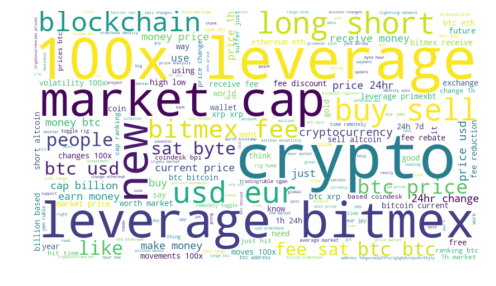

In [166]:
build_word_cloud(
    btc_tweets_preprocessed[btc_tweets_preprocessed.apply(no_hashtag_ratio) > 0.8],
    stopwords=sklearn.feature_extraction.text.ENGLISH_STOP_WORDS.union(stopwords))

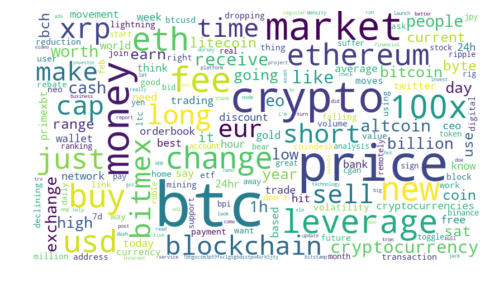

In [165]:
build_word_cloud(
    btc_tweets_preprocessed[btc_tweets_preprocessed.apply(no_hashtag_ratio) > 0.8],
    stopwords=sklearn.feature_extraction.text.ENGLISH_STOP_WORDS.union(stopwords),
    collocations=False)

In [163]:
sklearn.feature_extraction.text.ENGLISH_STOP_WORDS

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [169]:
btc_tweets_informative = btc_tweets_preprocessed[btc_tweets_preprocessed.apply(no_hashtag_ratio) > 0.8]

In [181]:
btc_tweets_informative_pred = pipe.predict(btc_tweets_informative)
1-btc_tweets_informative_pred

array([0, 0, 0, ..., 0, 1, 0])

In [178]:
btc_tweets_informative[btc_tweets_informative_pred]

0        rt techredef despite bitcoin's dive former soviet republic is still betting big on it lizalderma...
4        rt on cnbc etf edge vaneck ceo jan van eck said due to the shutdown vaneck wasn't able to contin...
6        rt jp morgan report bitcoin could fall below 1,260 while banks will not benefit from blockchain ...
7        catallaxy describes the process by which order emerges from the seeming chaos of countless indiv...
8        rt #btc #eth #ether #bitcoin falling wedge with ema resistance 0.0033183 btc large injection of ...
12       rt with bitcoin showing resilience to negative news flow strong bullish move is looking increasi...
14       rt alexander vinnik allegedly helped launder between billion and billion in bitcoin tied to cybe...
15       rt working on some big partnerships with notable players in the #crypto space stay tuned terawat...
16       rt analysts at jp morgan have predicted that #bitcoin btc could fall below 1,260 while banks wil...
17       rt #bitcoi

In [188]:
stopwords = ['bitcoin', 'rt', 'btc', 'crypto', 'price', 'blockchain', 'money', 'bitmex', 'ethereum', 'xrp', 'usd']

build_word_cloud(
    btc_tweets_informative[btc_tweets_informative_pred],
    stopwords=sklearn.feature_extraction.text.ENGLISH_STOP_WORDS.union(stopwords),
    collocations=False)

/Users/gdiazc/Google Drive/Data Incubator 2019/workspace/sentiment-dashboard/venv/lib/python3.7/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


TypeError: can only concatenate str (not "float") to str

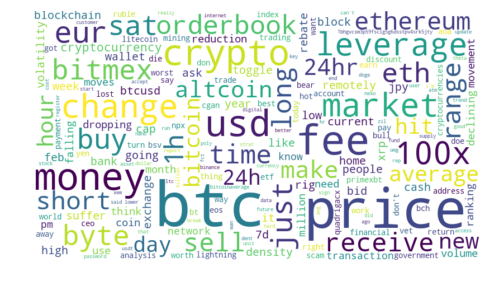

In [182]:
build_word_cloud(
    btc_tweets_informative[(1-btc_tweets_informative_pred).astype(bool)],
    stopwords=sklearn.feature_extraction.text.ENGLISH_STOP_WORDS.union(stopwords),
    collocations=False)

In [ ]:
positive_unigrams = ['bull', 'bullish', 'excited', 'epic', 'long', 'release']

In [ ]:
df_tweets['ih_sentiment'] = pipe.predict(df_tweets)

In [ ]:
df_tweets.head()

In [ ]:
df_tweets['ih_sentiment'].describe()

### 4.3. Wordcloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
stopwords=['https', 'co', 'rt', 'bitcoin', 'btc', 'the', 'for', 'and',
           'is', 'of', 'at', 'to', 'it', 'that', 'are', 'in']

In [ ]:
build_word_cloud(df_tweets[df_tweets['ih_sentiment'] == 0],
                 column_name='full_text_clean', stopwords=stopwords, collocations=False)

In [ ]:
build_word_cloud(df_tweets[df_tweets['ih_sentiment'] == 1],
                 column_name='full_text_clean', stopwords=stopwords, collocations=False)

In [ ]:
build_word_cloud(df_tweets,
                 column_name='full_text_clean', stopwords=stopwords, collocations=False)

In [ ]:
from collections import Counter
vocab = Counter()

for tweet in df_tweets['full_text_clean']:
    for token in tweet.split():
        vocab[token] += 1

print(len(vocab))

In [ ]:
pos_vocab = Counter()

for tweet in df_tweets[df_tweets['ih_sentiment'] == 1]['full_text_clean']:
    for token in tweet.split():
        pos_vocab[token] += 1

print(len(pos_vocab))

In [ ]:
neg_vocab = Counter()

for tweet in df_tweets[df_tweets['ih_sentiment'] == 0]['full_text_clean']:
    for token in tweet.split():
        neg_vocab[token] += 1

print(len(neg_vocab))

In [ ]:
i = 0
for key, val in vocab.items():
    print(f'{key}: {val}')
    i += 1
    if i > 10:
        break

In [ ]:
total_vocab = 0
for key, val in vocab.items():
    total_vocab += val
print(total_vocab)

In [ ]:
pos_total_vocab = 0
for key, val in pos_vocab.items():
    pos_total_vocab += val
print(pos_total_vocab)

In [ ]:
neg_total_vocab = 0
for key, val in neg_vocab.items():
    neg_total_vocab += val
print(neg_total_vocab)

In [ ]:
pos_term_importance = []

for key, val in pos_vocab.items():
    importance = (val / pos_total_vocab) / (vocab[key] / total_vocab)
    pos_term_importance.append((importance, key))

pos_term_importance = sorted(pos_term_importance, key=lambda item: -item[0])
print(pos_term_importance[:10])

In [ ]:
neg_term_importance = []

for key, val in neg_vocab.items():
    importance = (val / neg_total_vocab) / (vocab[key] / total_vocab)
    neg_term_importance.append((importance, key))

neg_term_importance = sorted(neg_term_importance, key=lambda item: -item[0])
print(neg_term_importance[:10])

In [ ]:
pos_term_importance[:100]

In [ ]:
neg_term_importance[:100]

In [ ]:
for tweet in df_tweets[df_tweets['ih_sentiment'] == 0]['full_text_clean']:
    if '#optionstrading' in tweet:
        print(tweet)

## 7. Model testing

## 8. Bokeh

In [ ]:
import bokeh
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [ ]:
output_notebook()

In [ ]:
df_tweets.head()

In [69]:
def get_tb_polarity(tweet):
    blob = textblob.TextBlob(tweet)
    sents = blob.sentences
    if len(sents) >= 1:
        sent = sents[0]
        return float(sent.sentiment.polarity)
    else:
        return np.NaN


In [ ]:
df_tweets['tb_polarity'] = df_tweets['full_text'].apply(get_tb_polarity)
df_tweets.head()

In [ ]:
df_tweets.dtypes

In [ ]:
df_tweets['tb_polarity'].describe()

In [ ]:
s_polarity = pd.Series(data=df_tweets['tb_polarity'].values, index=df_tweets['created_at'].values)
s_polarity = s_polarity.sort_index()
len(s_polarity)

In [ ]:
s_polarity = s_polarity.resample('H').mean()
print(len(s_polarity))
s_polarity.head()

In [ ]:
import bokeh.models

p = figure(
    plot_width=800, plot_height=450,
    tools="",
    x_axis_label='time', y_axis_label='polarity',
    x_axis_type='datetime'
)

# Format background colors:
low_box = bokeh.models.BoxAnnotation(top=0, fill_alpha=0.1, fill_color='red')
high_box = bokeh.models.BoxAnnotation(bottom=0, fill_alpha=0.1, fill_color='green')
p.add_layout(low_box)
p.add_layout(high_box)

# Format gridlines:
p.xgrid[0].grid_line_color=None
p.ygrid[0].grid_line_alpha=0.5

# Format view range:
p.y_range = bokeh.models.Range1d(-1.0, 1.0)

# Prepare data:
cd_source = bokeh.models.ColumnDataSource({'timestamp': s_polarity.index, 'polarity': s_polarity})

p.line('timestamp', 'polarity', source=cd_source, line_width=2)
p.circle('timestamp', 'polarity', source=cd_source, fill_color="white", size=2)

p.add_tools(bokeh.models.HoverTool(
    tooltips=[
        ('time', '@timestamp{%F %H:%M}'),
        ("polarity", "@polarity{+0.00}")
    ],
    formatters={'timestamp': 'datetime', 'polarity': 'numeral'},
    mode='vline'
))


In [ ]:
show(p)